In [ ]:
#!pip install transformers
#! rm -rf sample_data
#!git clone https://github.com/HickmannLautaro/BERT_classifier.git


In [ ]:
#cd BERT_classifier/

In [3]:
#######################################
### -------- Load libraries ------- ###

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import sklearn
import itertools
import io



In [4]:

#######################################
### --------- Import data --------- ###

# Import data from csv
data = pd.read_csv("amazon/train.csv")
test = pd.read_csv("amazon/test.csv")

data.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [5]:

# Select required columns
data = data[['Text', 'Cat1']]
test = test[['Text', 'Cat1']]
# Remove a row if any of the three remaining columns are missing
#data = data.dropna()
#test = test.dropna()


In [6]:
# Set your model output as categorical and save in new label col
data['Cat1_label'] = pd.Categorical(data['Cat1'])
# Transform your output to numeric
data['Cat1'] = data['Cat1_label'].cat.codes
data.head()

,Text,Cat1,Cat1_label
0,The description and photo on this product need...,2,grocery gourmet food
1,This was a great book!!!! It is well thought t...,5,toys games
2,"I am a first year teacher, teaching 5th grade....",5,toys games
3,I got the book at my bookfair at school lookin...,5,toys games
4,Hi! I'm Martine Redman and I created this puzz...,5,toys games


In [7]:

# Split into train and test - stratify over Issue
#data, data_test = train_test_split(data, test_size = 0.2, stratify = data[['Cat1']])



In [8]:
#######################################
### --------- Setup BERT ---------- ###

# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 300# 300

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
#######################################
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') # Ignores padded part of sentences
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
#inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
output = Dense(units=len(data.Cat1_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Cat1')(pooled_output)

# And combine it all in a model object
model = Model(inputs=inputs, outputs=output, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          ((None, 300, 768), ( 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]         

In [10]:
#######################################
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('accuracy')

#Checkpoints 
#filepath = "./chekpoints/lvl1/chek{epoch:02d}-{val_accuracy:.2f}"
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
y_Cat1 = to_categorical(data['Cat1'])

# Tokenize the input (takes some time)
x = tokenizer(
    text=data['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

test_x = tokenizer(
    text=test['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [11]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [12]:
logdir = "./logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=True)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [13]:


# Clear out prior logging data.
#!rm -rf logs/image


test['Cat1_label'] = pd.Categorical(test['Cat1'])
# Transform your output to numeric
test['Cat1'] = test['Cat1_label'].cat.codes
# Ready test data
test_y_cat1 = to_categorical(test['Cat1'])

class_names =np.unique(test['Cat1_label'])

#logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=True)
#file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']})
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test['Cat1'] , test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [14]:
#%load_ext tensorboard
#%tensorboard --logdir logs

In [15]:
# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    #x={'input_ids': x['input_ids']},
    y=y_Cat1,
    validation_split=0.2,
    batch_size=8,#8
    epochs=10,
    callbacks=[tensorboard_callback, cm_callback]) 


Epoch 1/10
   1/4000 [..............................] - ETA: 0s - loss: 1.9866 - accuracy: 0.1250WARNING:tensorflow:From /home/lautarohickmann/anaconda3/envs/Bert/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4000/4000 [==============================] - 3694s 924ms/step - loss: 0.4686 - accuracy: 0.8410 - val_loss: 0.4897 - val_accuracy: 0.8365
Epoch 2/10
4000/4000 [==============================] - 3701s 925ms/step - loss: 0.3265 - accuracy: 0.8908 - val_loss: 0.4884 - val_accuracy: 0.8388
Epoch 3/10
4000/4000 [==============================] - 3702s 925ms/step - loss: 0.3008 - accuracy: 0.9009 - val_loss: 0.4873 - val_accuracy: 0.8416
Epoch 4/10
4000/4000 [==============================] - 3708s 927ms/step - loss: 0.2867 - accuracy: 0.9059 - val_loss: 0.4887 - val_accuracy: 0.8429
Epoch 5/1

In [19]:
model.save('./saved_model_2/lvl1')

INFO:tensorflow:Assets written to: ./saved_model_2/lvl1/assets


In [ ]:
#model=tf.keras.models.load_model('saved_model_2/lvl1')

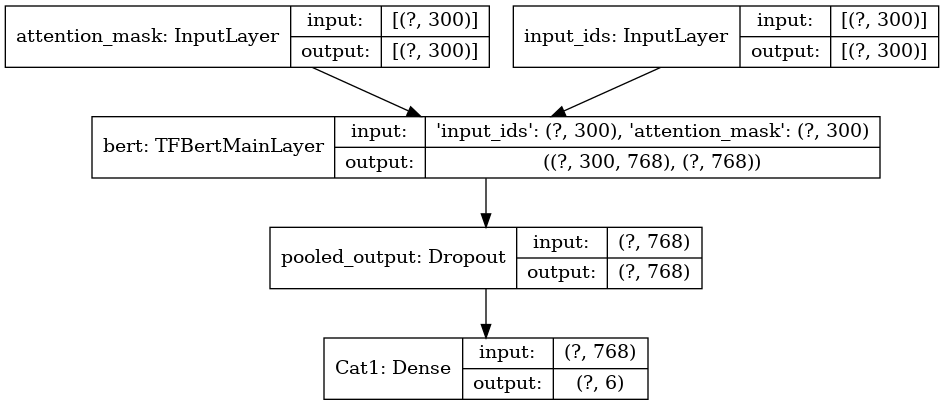

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file="./saved_model_2/lvl1/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


In [21]:
#######################################
### ----- Evaluate the model ------ ###
# Set your model output as categorical and save in new label col
#test['Cat1_label'] = pd.Categorical(test['Cat1'])
# Transform your output to numeric
#test['Cat1'] = test['Cat1_label'].cat.codes
# Ready test data
#test_y_cat1 = to_categorical(test['Cat1'])

test_x = tokenizer(
    text=test['Text'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [22]:

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},
    y=test_y_cat1)

313/313 [==============================] - 314s 1s/step - loss: 0.5548 - accuracy: 0.8241


In [30]:
test_pred_raw = model.predict(x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']}, verbose=1, callbacks=[tensorboard_callback, cm_callback]) 

test_pred = np.argmax(test_pred_raw, axis=1)

# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(test['Cat1'] , test_pred)
# Log the confusion matrix as an image summary.
figure = plot_confusion_matrix(cm, class_names=class_names)
figure.savefig('./saved_model_2/lvl1/conf.png')
plt.show()

 45/313 [===>..........................] - ETA: 4:17

KeyboardInterrupt: 

In [ ]:
np.savez("./saved_model_2/lvl1/test_pred_raw.npz", test_pred_raw=test_pred_raw)